# Test 1

> Test Fast.ai install

In [1]:
#| default_exp test1

In [2]:
#| hide
from nbdev.showdoc import *

%matplotlib inline
from fastai.vision.all import *
from fastai.data.all import *
import torch.nn.functional as F

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

/home/biagio/miniconda3/envs/n2m/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
bs, size = 4, 512
# arch = models.resnet34
path = Path('../_data/Confocal_BPAE_B/')
path_train_raw = Path(path/"raw")
path_train_gt = Path(path/"gt")

7


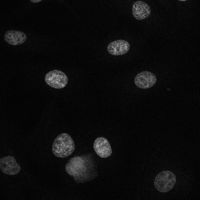

In [4]:
fnames = get_image_files(path_train_raw)
print(parent_label(fnames[0]))
Image.open(fnames[0]).to_thumb(200)

In [5]:
from Noise2Model.core import *

In [6]:
fnames1 = fnames[0]
print(fnames1)
fnames2 = get_noisy_pair(fnames1)
print(fnames2)

../_data/Confocal_BPAE_B/raw/7/HV110_P0500510020.png
../_data/Confocal_BPAE_B/raw/7/HV110_P0500510044.png


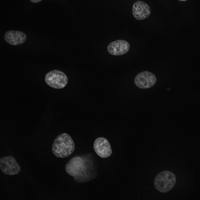

In [7]:
my_get_gt = get_gt(path)
Image.open(my_get_gt(fnames[0])).to_thumb(200)

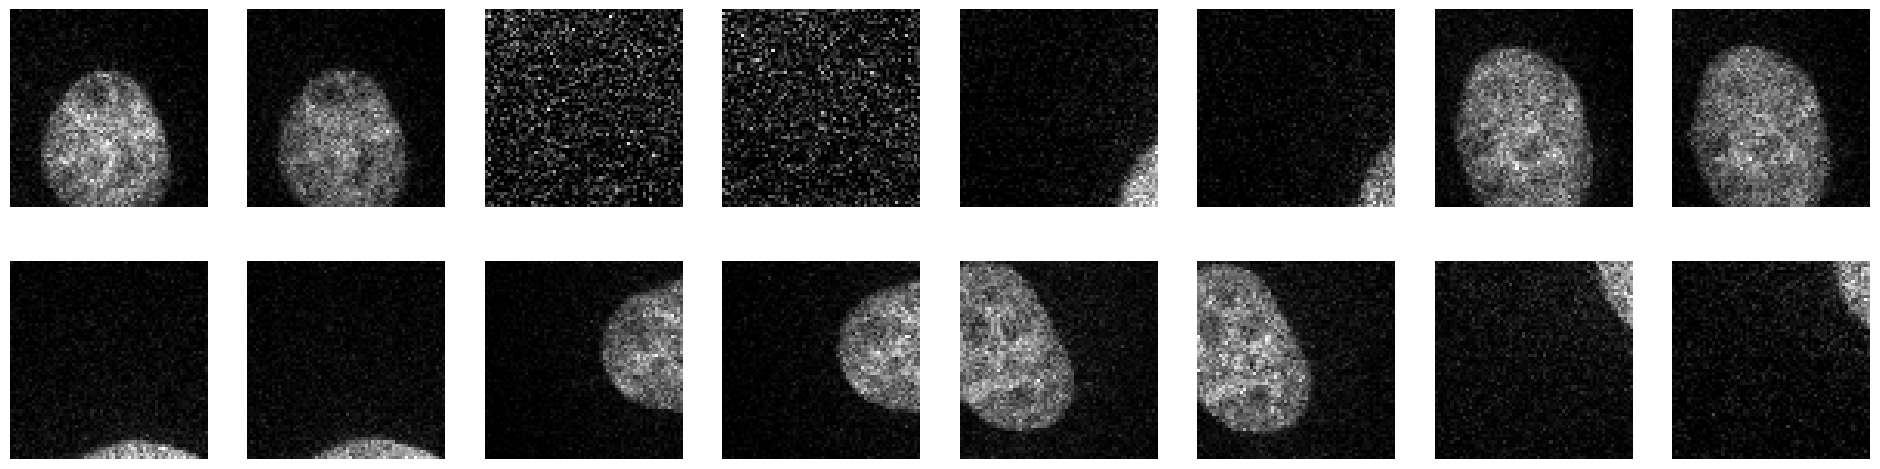

In [9]:
dblock = DataBlock(blocks    = (ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                   get_items = get_image_files, 
                   get_y = get_noisy_pair,
                   splitter  = RandomSplitter(valid_pct=0.2),
                   item_tfms = RandomCrop(64),
                   )
# dblock.summary(path_train_raw)
# dsets = dblock.datasets(path_train_raw)
# dsets.train[0]
dls = dblock.dataloaders(path_train_raw)
dls.show_batch(max_n=8, cmap='gray')

In [ ]:
# from fastai.layers import *
ks = 3
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            ConvLayer(1, 12, ks=ks),            # [batch, 12, 16, 16]
            ConvLayer(12, 24, ks=ks),           # [batch, 24, 8, 8]
            ConvLayer(24, 48, ks=ks),           # [batch, 48, 4, 4]
        )
        self.decoder = nn.Sequential(
            ConvLayer(48, 24, ks=ks, transpose=True, padding=(ks-1)//2),  # [batch, 24, 8, 8]
            ConvLayer(24, 12, ks=ks, transpose=True, padding=(ks-1)//2),  # [batch, 12, 16, 16]
            ConvLayer(12, 1, ks=ks, transpose=True, padding=(ks-1)//2, act_cls=None),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    def encode(self, x): return self.encoder(x)
    
    def decode(self, x): return self.decoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return x - decoded

In [ ]:
autoencoder = Autoencoder()
learn = Learner(dls, autoencoder, loss_func = F.l1_loss)
learn.lr_find()
# learn.model

In [ ]:
learn.fit_one_cycle(20, lr_max = 1e-02)

In [ ]:
learn.show_results(max_n=10, cmap='gray')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()